# Gesture Recognition

In this project, you are going to build a 3D Conv models and Conv2D+LSTM/GRU models that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

## Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

Thumbs up: Increase the volume

Thumbs down: Decrease the volume

Left swipe: 'Jump' backwards 10 seconds

Right swipe: 'Jump' forward 10 seconds

Stop: Pause the movie

## Understanding the Dataset
The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.

Note that all images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). Hence, you will need to do some pre-processing to standardise the videos.

Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.

Your task is to train a model on the 'train' folder which performs well on the 'val' folder as well.

In [3]:
import numpy as np
import os
import imageio
from skimage.transform import resize, rescale
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [1]:
#%tensorflow_version 1.x

In [4]:
import tensorflow as tf
import numpy as np
print(tf.__version__)
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
tf.compat.v1.disable_eager_execution()
#tf.set_random_seed(30)

2023-09-28 23:42:33.567464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0


In [ ]:
#from zipfile import ZipFile
#with ZipFile('/content/drive/My Drive/Colab Notebooks/Project_data.zip','r') as zip:
#    zip.extractall()

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [8]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
num_classes = 5  #number of softmax classes
print(train_doc)
print(val_doc)

['WIN_20180907_16_38_29_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0\n'
 'WIN_20180926_17_15_56_Pro_Right_Swipe_new;Right_Swipe_new;1\n'
 'WIN_20180926_17_33_51_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180907_15_43_28_Pro_Right Swipe_new;Right Swipe_new;1\n'
 'WIN_20180926_16_49_49_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180926_17_02_27_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180926_17_18_02_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180907_16_12_53_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0\n'
 'WIN_20180926_17_28_21_Pro_Right_Swipe_new;Right_Swipe_new;1\n'
 'WIN_20180926_17_24_33_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180907_15_46_43_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0\n'
 'WIN_20180907_15_55_27_Pro_Thumbs Down_new;Thumbs Down_new;3\n'
 'WIN_20180925_17_28_48_Pro_Stop_new;Stop_new;2\n'
 'WIN_20180925_17_34_40_Pro_Right_Swipe_new;Right_Swipe_new;1\n'
 'WIN_20180926_17_33_51_Pro_Thumbs_Down_

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Common Utils

Common utility to plot loss and accuracy

In [10]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Common utility to calculate steps

In [11]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

Common utility for callbacks

In [12]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]    

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image1 = imageio.imread("./Project_data/val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00029.png")
/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imageio.imread("./Project_data/val/WIN_20180926_17_56_52_Pro_Right_Swipe_new/WIN_20180926_17_56_52_Pro_00029.png")


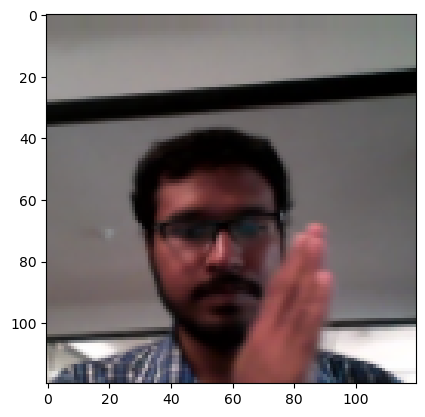

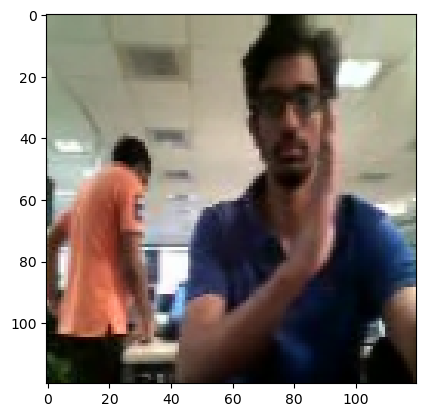

In [14]:
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import smart_resize

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

## Test code start
#360 by 360
image1 = imageio.imread("./Project_data/val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00029.png")
#160 by 120
image2 = imageio.imread("./Project_data/val/WIN_20180926_17_56_52_Pro_Right_Swipe_new/WIN_20180926_17_56_52_Pro_00029.png")
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes                    
#print(image1.shape, image2.shape)
image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)                   
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)                 
plt.imshow(image2)
plt.show()
## Test code end

def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        #img_idx = sorted(rn.sample(range(0, total_frames), num_images)) #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    #batch_data[folder,idx,:,:,0] = (image[...,0] - image[...,0].min())/(image[...,0].max() - image[...,0].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] = (image[...,1] - image[...,1].min())/(image[...,1].max() - image[...,1].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] = (image[...,2] - image[...,2].min())/(image[...,2].max() - image[...,2].min())#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

### Conv3d Models

In [16]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

#### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)


In [21]:
num_epochs = 20 # 25 choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 30
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_14 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                            

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [22]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [23]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/3465535719.py:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
55/67 [=======================>......] - ETA: 1:07 - batch: 27.0000 - size: 10.0000 - loss: 1.7064 - categorical_accuracy: 0.3945

/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.6829 - categorical_accuracy: 0.4042 
Epoch 1: val_loss improved from inf to 7.17358, saving model to model_conv3D_1_2023-09-2823_44_41.504980/model-00001-1.67305-0.40422-7.17358-0.22000.h5
67/67 [==============================] - 397s 6s/step - batch: 33.0000 - size: 9.8955 - loss: 1.6827 - categorical_accuracy: 0.4042 - val_loss: 7.1736 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.3263 - categorical_accuracy: 0.4962 
Epoch 2: val_loss improved from 7.17358 to 3.23755, saving model to model_conv3D_1_2023-09-2823_44_41.504980/model-00002-1.31519-0.49623-3.23755-0.37000.h5
67/67 [==============================] - 400s 6s/step - batch: 33.0000 - size: 9.8955 - loss: 1.3262 - categorical_accuracy: 0.4962 - val_loss: 3.2376 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 3/20
67/67 [=========

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


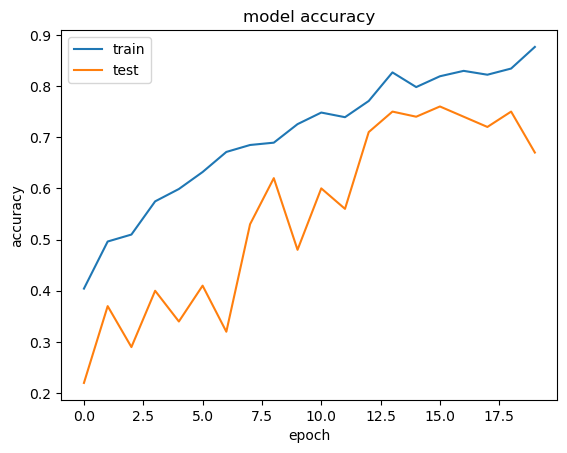

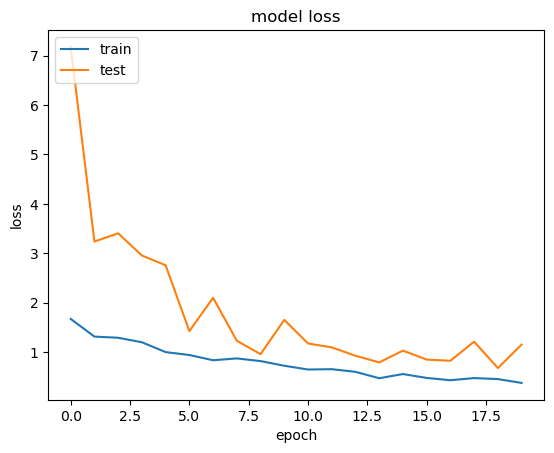

In [24]:
plot_loss_accuracy(history)

#### Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [25]:
num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# batch size = 10
# num_frames per video = 20
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_21 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 60, 60, 32)    13856     
                                                                 
 activat

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [26]:
callbacks_list = model_callbacks("model_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [27]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2827218171.py:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
55/67 [=======================>......] - ETA: 43s - batch: 27.0000 - size: 10.0000 - loss: 1.5876 - categorical_accuracy: 0.4436

/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.5993 - categorical_accuracy: 0.4404 
Epoch 1: val_loss improved from inf to 3.13575, saving model to model_conv3D_2_2023-09-2823_44_41.504980/model-00001-1.58471-0.44042-3.13575-0.20000.h5
67/67 [==============================] - 283s 4s/step - batch: 33.0000 - size: 9.8955 - loss: 1.5991 - categorical_accuracy: 0.4404 - val_loss: 3.1358 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.2585 - categorical_accuracy: 0.5445 
Epoch 2: val_loss improved from 3.13575 to 3.02891, saving model to model_conv3D_2_2023-09-2823_44_41.504980/model-00002-1.26545-0.54449-3.02891-0.27000.h5
67/67 [==============================] - 264s 4s/step - batch: 33.0000 - size: 9.8955 - loss: 1.2586 - categorical_accuracy: 0.5445 - val_loss: 3.0289 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/20
67/67 [=========

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


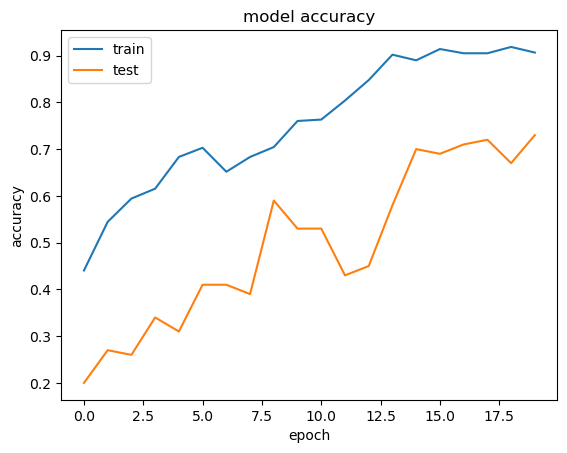

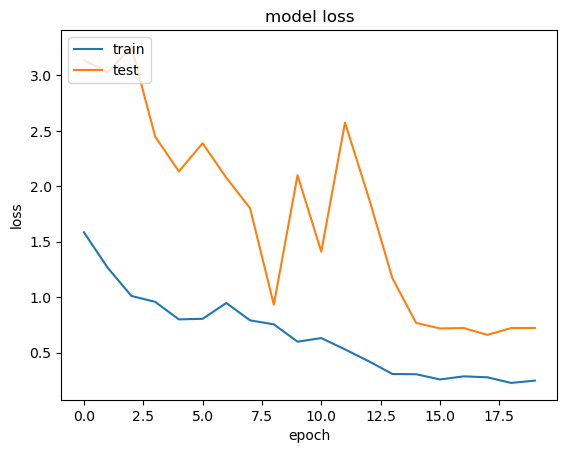

In [28]:
plot_loss_accuracy(history)

#### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160)

In [29]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 30
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_28 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 15, 80, 80, 32)    13856     
                                                            

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [30]:
callbacks_list = model_callbacks("model_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

In [31]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2827218171.py:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
55/67 [=======================>......] - ETA: 2:17 - batch: 27.0000 - size: 10.0000 - loss: 1.4965 - categorical_accuracy: 0.4709

/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.4391 - categorical_accuracy: 0.4887  
Epoch 1: val_loss improved from inf to 7.24487, saving model to model_conv3D_3_2023-09-2823_44_41.504980/model-00001-1.45314-0.48869-7.24487-0.16000.h5
67/67 [==============================] - 786s 12s/step - batch: 33.0000 - size: 9.8955 - loss: 1.4393 - categorical_accuracy: 0.4887 - val_loss: 7.2449 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.1644 - categorical_accuracy: 0.5852  
Epoch 2: val_loss improved from 7.24487 to 2.33754, saving model to model_conv3D_3_2023-09-2823_44_41.504980/model-00002-1.15326-0.58522-2.33754-0.28000.h5
67/67 [==============================] - 743s 11s/step - batch: 33.0000 - size: 9.8955 - loss: 1.1642 - categorical_accuracy: 0.5852 - val_loss: 2.3375 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/20
67/67 [=====

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


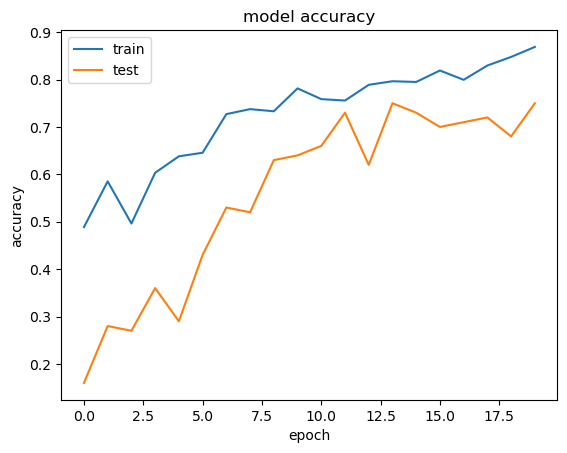

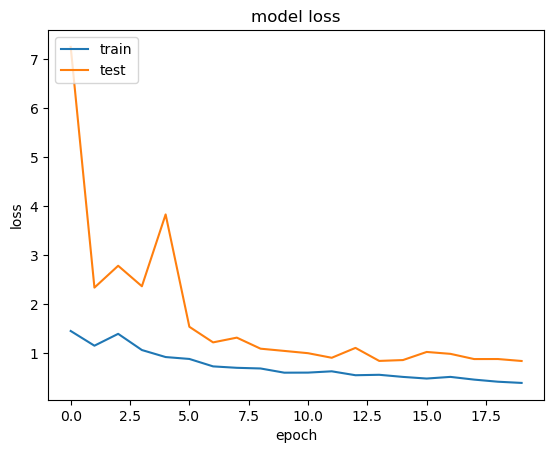

In [32]:
plot_loss_accuracy(history)

#### Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160)

In [33]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_35 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                            

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [34]:
callbacks_list = model_callbacks("model_conv3D_4")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

In [35]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2827218171.py:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
55/67 [=======================>......] - ETA: 1:22 - batch: 27.0000 - size: 10.0000 - loss: 1.6660 - categorical_accuracy: 0.3964

/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.6025 - categorical_accuracy: 0.4072 
Epoch 1: val_loss improved from inf to 2.38670, saving model to model_conv3D_4_2023-09-2823_44_41.504980/model-00001-1.60948-0.40724-2.38670-0.20000.h5
67/67 [==============================] - 486s 7s/step - batch: 33.0000 - size: 9.8955 - loss: 1.6026 - categorical_accuracy: 0.4072 - val_loss: 2.3867 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.1860 - categorical_accuracy: 0.5490 
Epoch 2: val_loss did not improve from 2.38670
67/67 [==============================] - 472s 7s/step - batch: 33.0000 - size: 9.8955 - loss: 1.1859 - categorical_accuracy: 0.5490 - val_loss: 3.5349 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 0.9637 - categorical_accuracy: 0.630

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


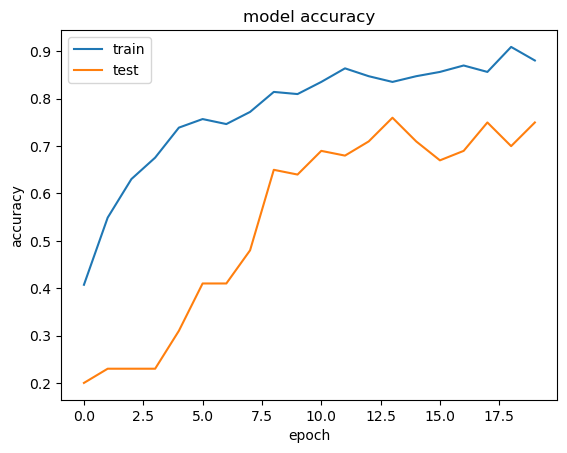

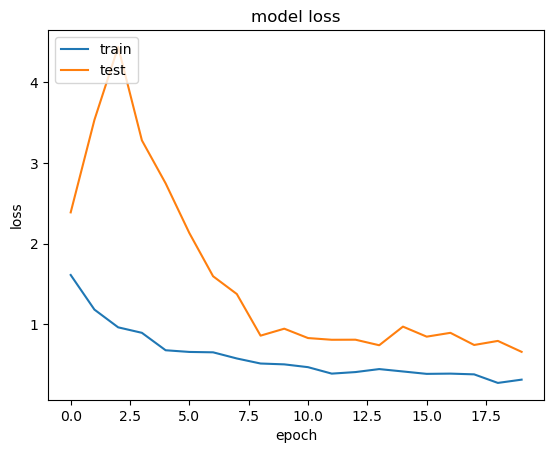

In [36]:
plot_loss_accuracy(history)

#### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer) + Random data transformations on training data set

In [37]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_42 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_36 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                            

In [38]:
callbacks_list = model_callbacks("model_conv3D_5")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [39]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2827218171.py:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/15
55/67 [=======================>......] - ETA: 1:09 - batch: 27.0000 - size: 10.0000 - loss: 1.7768 - categorical_accuracy: 0.3800

/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.7943 - categorical_accuracy: 0.3801 
Epoch 1: val_loss improved from inf to 2.66664, saving model to model_conv3D_5_2023-09-2823_44_41.504980/model-00001-1.77867-0.38009-2.66664-0.25000.h5
67/67 [==============================] - 423s 6s/step - batch: 33.0000 - size: 9.8955 - loss: 1.7941 - categorical_accuracy: 0.3801 - val_loss: 2.6666 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.3248 - categorical_accuracy: 0.5113 
Epoch 2: val_loss improved from 2.66664 to 2.46413, saving model to model_conv3D_5_2023-09-2823_44_41.504980/model-00002-1.30104-0.51131-2.46413-0.32000.h5
67/67 [==============================] - 434s 6s/step - batch: 33.0000 - size: 9.8955 - loss: 1.3245 - categorical_accuracy: 0.5113 - val_loss: 2.4641 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/15
67/67 [=========

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


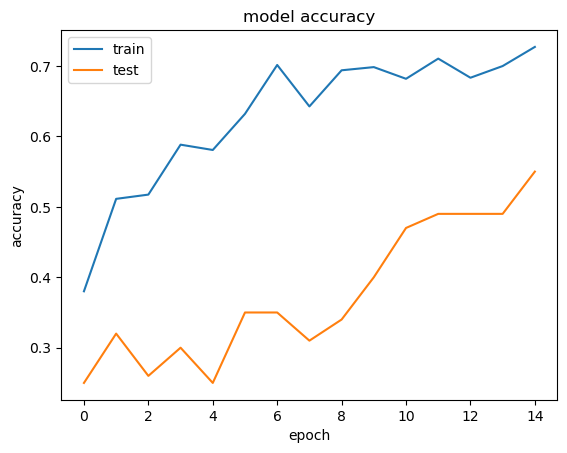

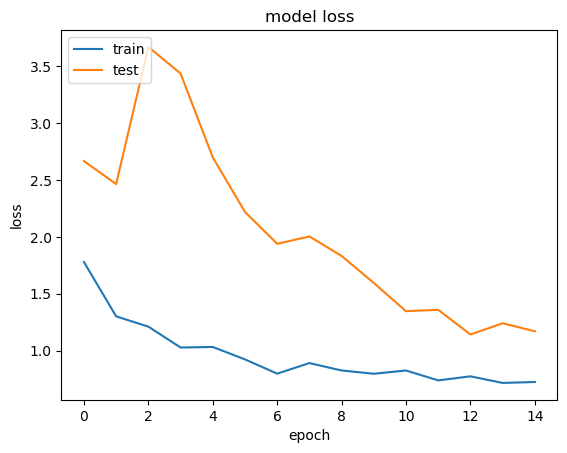

In [40]:
plot_loss_accuracy(history)

#### Conv 3D Model with 20 frames per video (32, 64, 128, 256) filters conv 3D layers + 128 dense layer + 128 dense layer + image size 120 by 120)

In [41]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (32, 64, 128, 256)
dense_filters = (128, 128)
model = conv3D(conv_filters=conv_filters,dense_nodes=dense_filters, num_images=num_frames)
print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 20


/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 20, 120, 120, 32)  2624      
                                                                 
 activation_49 (Activation)  (None, 20, 120, 120, 32)  0         
                                                                 
 batch_normalization_42 (Bat  (None, 20, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 10, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 10, 60, 60, 64)    55360     
                                                                 
 activation_50 (Activation)  (None, 10, 60, 60, 64)   

In [42]:
callbacks_list = model_callbacks("model_conv3D_8")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=False, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [43]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2827218171.py:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/25
55/67 [=======================>......] - ETA: 1:52 - batch: 27.0000 - size: 10.0000 - loss: 1.6481 - categorical_accuracy: 0.3764

/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.6056 - categorical_accuracy: 0.3876 
Epoch 1: val_loss improved from inf to 1.55148, saving model to model_conv3D_8_2023-09-2823_44_41.504980/model-00001-1.61179-0.38763-1.55148-0.34000.h5
67/67 [==============================] - 660s 10s/step - batch: 33.0000 - size: 9.8955 - loss: 1.6057 - categorical_accuracy: 0.3876 - val_loss: 1.5515 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.3207 - categorical_accuracy: 0.4827 
Epoch 2: val_loss did not improve from 1.55148
67/67 [==============================] - 646s 10s/step - batch: 33.0000 - size: 9.8955 - loss: 1.3208 - categorical_accuracy: 0.4827 - val_loss: 3.3457 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.1612 - categorical_accuracy: 0.5

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


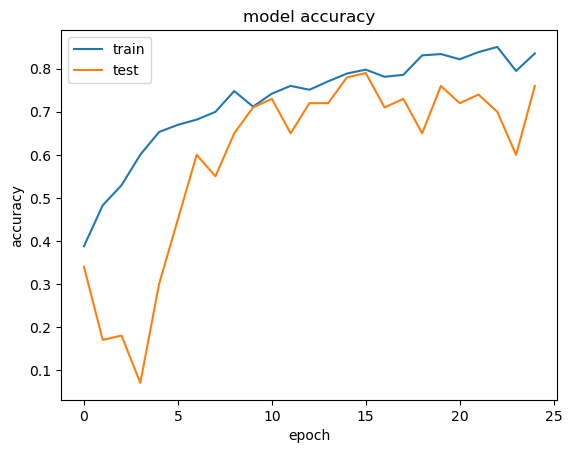

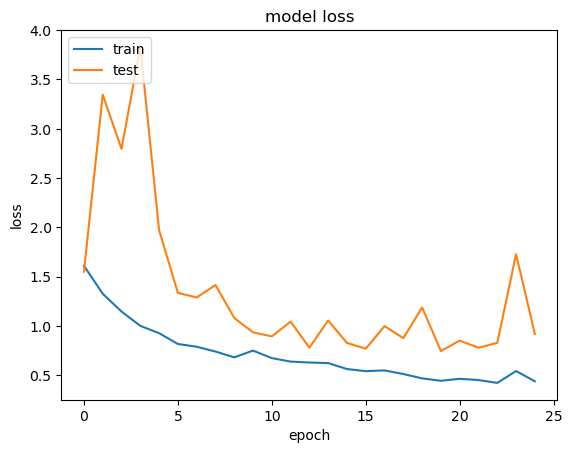

In [44]:
plot_loss_accuracy(history)

#### Conv 3D Model with 30 frames per video and a 5 by 5 filter size (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [45]:
#write your model here
def conv3D_5by5(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (5, 5, 5), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

In [46]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D_5by5(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30


/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 30, 120, 120, 16)  6016      
                                                                 
 activation_56 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_48 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 activation_57 (Activation)  (None, 15, 60, 60, 32)   

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [47]:
callbacks_list = model_callbacks("model_conv3D_9")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


In [48]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2827218171.py:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/15
55/67 [=======================>......] - ETA: 2:40 - batch: 27.0000 - size: 10.0000 - loss: 1.7210 - categorical_accuracy: 0.3891

/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.6883 - categorical_accuracy: 0.3982  
Epoch 1: val_loss improved from inf to 4.66238, saving model to model_conv3D_9_2023-09-2823_44_41.504980/model-00001-1.68203-0.39819-4.66238-0.28000.h5
67/67 [==============================] - 942s 14s/step - batch: 33.0000 - size: 9.8955 - loss: 1.6882 - categorical_accuracy: 0.3982 - val_loss: 4.6624 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - batch: 33.0000 - size: 9.8955 - loss: 1.2867 - categorical_accuracy: 0.5249  
Epoch 2: val_loss improved from 4.66238 to 2.11217, saving model to model_conv3D_9_2023-09-2823_44_41.504980/model-00002-1.29525-0.52489-2.11217-0.28000.h5
67/67 [==============================] - 923s 14s/step - batch: 33.0000 - size: 9.8955 - loss: 1.2868 - categorical_accuracy: 0.5249 - val_loss: 2.1122 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/15
67/67 [=====

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


/var/folders/0v/j5_0v1hd0n5673krlg7kmnh00000gn/T/ipykernel_11414/2750340108.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


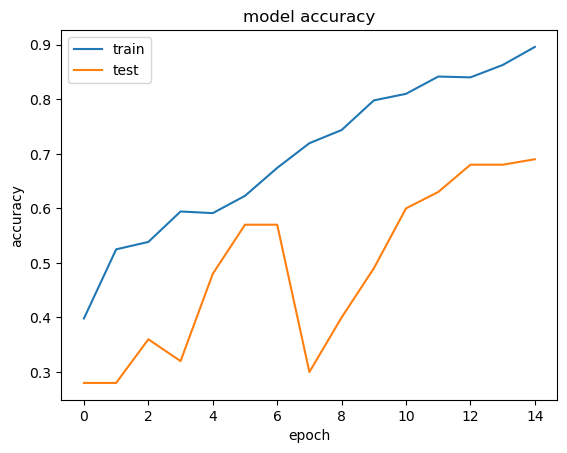

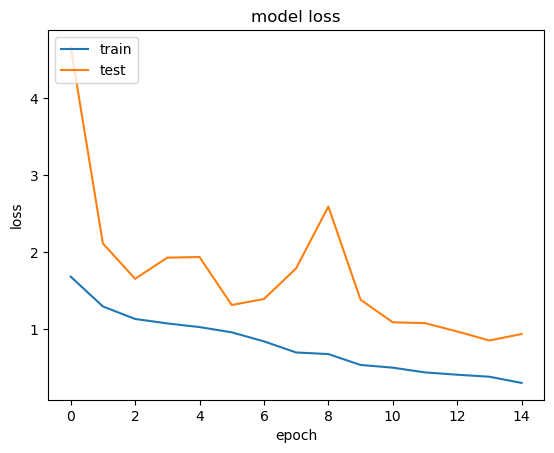

In [49]:
plot_loss_accuracy(history)